In [49]:
# %%
# =============================================================================
# Passo 1: Importação de Bibliotecas
# =============================================================================

# Bibliotecas padrão
import csv
from pathlib import Path

# Bibliotecas de terceiros para análise e manipulação de dados
import numpy as np
import pandas as pd
import openpyxl
from scipy.stats import skew, kurtosis, ttest_ind

# Bibliotecas para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Ferramentas de pré-processamento do Scikit-learn
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

In [2]:
# %%
# Passo 2: Caminho relativo até a pasta com os CSVs
# (o notebook está na raiz do projeto)
pasta_csvs = Path.cwd() / "Bases" / "0_RAIS_Bases_Amostra" / "RAIS_Enap_amostra_"
assert pasta_csvs.exists(), f"Pasta não encontrada: {pasta_csvs}"

# Listar CSVs (case-insensitive)
arquivos_csv = sorted([p for p in pasta_csvs.glob("*.csv")])
print(f"Arquivos encontrados: {len(arquivos_csv)}")
for p in arquivos_csv[:10]:
    print(" -", p.name)
if not arquivos_csv:
    raise FileNotFoundError("Nenhum CSV encontrado na pasta indicada.")


Arquivos encontrados: 11
 - RAIS_2014_Enap_amostra.csv
 - RAIS_2015_Enap_amostra.csv
 - RAIS_2016_Enap_amostra.csv
 - RAIS_2017_Enap_amostra.csv
 - RAIS_2018_Enap_amostra.csv
 - RAIS_2019_Enap_amostra.csv
 - RAIS_2020_Enap_amostra.csv
 - RAIS_2021_Enap_amostra.csv
 - RAIS_2022_Enap_amostra.csv
 - RAIS_2023_Enap_amostra.csv


In [3]:
# %%
# Passo 3: Função para detectar delimitador (';' ou ',') a partir de uma amostra
def detectar_delimitador(caminho_arquivo: Path, tamanho_amostra: int = 65536) -> str:
    with caminho_arquivo.open("rb") as f:
        amostra = f.read(tamanho_amostra)
    # Tentar decodificações comuns rapidamente só para o sniffer
    for enc in ("utf-8", "latin-1", "cp1252"):
        try:
            texto = amostra.decode(enc, errors="strict")
            dialect = csv.Sniffer().sniff(texto, delimiters=";,")
            return dialect.delimiter
        except Exception:
            continue
    # Se nada der certo, cair para ';' (comum em bases brasileiras)
    return ";"


In [5]:
# %%
def ler_csv_robusto(caminho_arquivo: Path) -> pd.DataFrame:
    sep_detectado = detectar_delimitador(caminho_arquivo)
    encodings = ("utf-8-sig", "utf-8", "latin-1", "cp1252")
    erros = []

    # 1) Tenta engine C (suporta low_memory)
    for enc in encodings:
        try:
            return pd.read_csv(
                caminho_arquivo,
                sep=sep_detectado,
                encoding=enc,
                low_memory=False,   # OK com engine C
                engine="c"
            )
        except Exception as e:
            erros.append((f"engine=c | {enc}", str(e)))

    # 2) Fallback: engine Python (NÃO usar low_memory)
    for enc in encodings:
        try:
            return pd.read_csv(
                caminho_arquivo,
                sep=sep_detectado,
                encoding=enc,
                engine="python",
                on_bad_lines="skip"  # mais tolerante
            )
        except Exception as e:
            erros.append((f"engine=python | {enc}", str(e)))

    msg = f"Falha ao ler {caminho_arquivo.name}. Tentativas e erros:\n"
    msg += "\n".join([f" - {ctx}: {err}" for ctx, err in erros])
    raise RuntimeError(msg)


In [6]:
# %%
# Passo 5: Ler todos os CSVs e concatenar
dataframes = []
for idx, arq in enumerate(arquivos_csv, start=1):
    print(f"[{idx}/{len(arquivos_csv)}] Lendo: {arq.name} ...", end="")
    df_tmp = ler_csv_robusto(arq)
    dataframes.append(df_tmp)
    print(f" ok ({df_tmp.shape[0]} linhas, {df_tmp.shape[1]} colunas)")

df_rais = pd.concat(dataframes, ignore_index=True)
print("\nConcatenação concluída.")
print("Dimensão final:", df_rais.shape)


[1/11] Lendo: RAIS_2014_Enap_amostra.csv ... ok (1128887 linhas, 37 colunas)
[2/11] Lendo: RAIS_2015_Enap_amostra.csv ... ok (1090572 linhas, 37 colunas)
[3/11] Lendo: RAIS_2016_Enap_amostra.csv ... ok (726162 linhas, 37 colunas)
[4/11] Lendo: RAIS_2017_Enap_amostra.csv ... ok (1073850 linhas, 37 colunas)
[5/11] Lendo: RAIS_2018_Enap_amostra.csv ... ok (1082710 linhas, 37 colunas)
[6/11] Lendo: RAIS_2019_Enap_amostra.csv ... ok (796532 linhas, 37 colunas)
[7/11] Lendo: RAIS_2020_Enap_amostra.csv ... ok (1109627 linhas, 37 colunas)
[8/11] Lendo: RAIS_2021_Enap_amostra.csv ... ok (1199769 linhas, 37 colunas)
[9/11] Lendo: RAIS_2022_Enap_amostra.csv ... ok (1245516 linhas, 37 colunas)
[10/11] Lendo: RAIS_2023_Enap_amostra.csv ... ok (1328596 linhas, 37 colunas)
[11/11] Lendo: RAIS_2024_Enap_amostra.csv ... ok (985182 linhas, 37 colunas)

Concatenação concluída.
Dimensão final: (11767403, 37)


In [7]:
# %%
# Passo 6: Quick check
print("Colunas:", list(df_rais.columns))
display(df_rais.head(10))


Colunas: ['NRANO', 'CDMunicipio', 'VinculoAtivo', 'TPVinculo', 'CDDesligamento', 'NRMesDesligamento', 'TPAdmissao', 'TPSalario', 'CDGrauEscolaridade', 'CDSexo', 'CDRacaCor', 'INPortadorDefic', 'CDTamanhoEstabelecimento', 'CDNaturezaJuridica', 'TPEstabelecimento', 'DTAdmissaoDeclarada', 'VLRemunMediaNom', 'VLRemunMediaSM', 'VLRemunDezembroNom', 'VLRemunDezembroSM', 'NRTempoEmprego', 'NRQtdHoraContr', 'VLSalarioContratual', 'NRCNPJCEI', 'NRCNPJRaiz', 'CDCBOOcupacao2002', 'CDCNAE20Classe', 'CDCNAE20Subclasse', 'TPDeficiencia', 'CDCausaAfastamento1', 'CDCausaAfastamento2', 'CDCausaAfastamento3', 'NRIdade', 'INTrabIntermitente', 'INTrabParcial', 'Estoque_Total', 'Estoque_Fem']


,NRANO,CDMunicipio,VinculoAtivo,TPVinculo,CDDesligamento,NRMesDesligamento,TPAdmissao,TPSalario,CDGrauEscolaridade,CDSexo,...,CDCNAE20Subclasse,TPDeficiencia,CDCausaAfastamento1,CDCausaAfastamento2,CDCausaAfastamento3,NRIdade,INTrabIntermitente,INTrabParcial,Estoque_Total,Estoque_Fem
0,2014,520650,1,35,0.0,0.0,0.0,1.0,7.0,1.0,...,8411600.0,0.0,99.0,99.0,99.0,48.0,0.0,0.0,242.0,169.0
1,2014,530010,1,30,0.0,0.0,0.0,1.0,9.0,2.0,...,8411600.0,0.0,30.0,30.0,30.0,38.0,0.0,0.0,6135.0,2523.0
2,2014,351880,1,10,0.0,0.0,2.0,1.0,3.0,1.0,...,4930202.0,0.0,99.0,99.0,99.0,34.0,0.0,0.0,340.0,48.0
3,2014,354780,1,10,0.0,0.0,0.0,1.0,7.0,2.0,...,8011101.0,0.0,99.0,99.0,99.0,25.0,0.0,0.0,4898.0,529.0
4,2014,330190,1,30,0.0,0.0,0.0,1.0,9.0,2.0,...,8411600.0,0.0,40.0,99.0,99.0,35.0,0.0,0.0,7321.0,4828.0
5,2014,293330,1,10,0.0,0.0,1.0,5.0,5.0,2.0,...,1531901.0,0.0,99.0,99.0,99.0,20.0,0.0,0.0,773.0,592.0
6,2014,220390,1,30,0.0,0.0,0.0,1.0,7.0,2.0,...,8411600.0,0.0,99.0,99.0,99.0,29.0,0.0,0.0,467.0,302.0
7,2014,421130,1,30,0.0,0.0,0.0,1.0,7.0,2.0,...,8411600.0,0.0,99.0,99.0,99.0,33.0,0.0,0.0,2510.0,1869.0
8,2014,130260,1,10,0.0,0.0,0.0,1.0,7.0,1.0,...,5320201.0,0.0,99.0,99.0,99.0,27.0,0.0,0.0,345.0,252.0
9,2014,211130,1,10,0.0,0.0,0.0,1.0,7.0,1.0,...,1092900.0,1.0,99.0,99.0,99.0,37.0,0.0,0.0,433.0,181.0


In [8]:
# %%
colunas_para_remover = [
    "VinculoAtivo",
    "NRMesDesligamento",
    "TPAdmissao",
    "TPEstabelecimento",
    "TPDeficiencia",
    "CDCausaAfastamento1",
    "CDCausaAfastamento2",
    "CDCausaAfastamento3",
    "INTrabIntermitente",
]

existentes = [c for c in colunas_para_remover if c in df_rais.columns]
ausentes = [c for c in colunas_para_remover if c not in df_rais.columns]

df_rais_filtrado = df_rais.drop(columns=existentes, errors="ignore")

print(f"Removidas: {existentes}")
if ausentes:
    print(f"Não encontradas (ignoradas): {ausentes}")
print("Shape antes:", df_rais.shape, " | depois:", df_rais_filtrado.shape)


Removidas: ['VinculoAtivo', 'NRMesDesligamento', 'TPAdmissao', 'TPEstabelecimento', 'TPDeficiencia', 'CDCausaAfastamento1', 'CDCausaAfastamento2', 'CDCausaAfastamento3', 'INTrabIntermitente']
Shape antes: (11767403, 37)  | depois: (11767403, 28)


In [9]:
# %%

# 1) Cópia para normalização
df_rais_norm = df_rais_filtrado.copy()

# 2) Função para decodificar bytes/bytearray em texto
def decodificar_para_str(v):
    if isinstance(v, (bytes, bytearray)):
        try:
            return v.decode("utf-8")
        except UnicodeDecodeError:
            return v.decode("latin-1", errors="replace")
    return v

# 3) Converter todas as colunas object para string, decodificando bytes
cols_obj = df_rais_norm.select_dtypes(include=["object"]).columns.tolist()
for c in cols_obj:
    df_rais_norm[c] = df_rais_norm[c].map(decodificar_para_str)
    df_rais_norm[c] = df_rais_norm[c].astype("string")

# 3.1) Garantia extra para a coluna problemática citada no erro
if "CDCBOOcupacao2002" in df_rais_norm.columns:
    df_rais_norm["CDCBOOcupacao2002"] = df_rais_norm["CDCBOOcupacao2002"].astype("string")

# 4) (Opcional) Verificação: sobrou alguma coluna com bytes?
def colunas_com_bytes(df: pd.DataFrame):
    achadas = []
    for c in df.columns:
        s = df[c]
        if s.dtype == "object" or pd.api.types.is_string_dtype(s):
            if s.dropna().apply(lambda v: isinstance(v, (bytes, bytearray))).any():
                achadas.append(c)
    return achadas

resto = colunas_com_bytes(df_rais_norm)
print("Colunas ainda com bytes:", resto)

# 5) Salvar em Parquet (Snappy) na mesma pasta dos CSVs
saida_parquet = pasta_csvs / "RAIS_Enap_amostra_filtrado.parquet"

engine = None
try:
    import pyarrow  # noqa: F401
    engine = "pyarrow"
except Exception:
    try:
        import fastparquet  # noqa: F401
        engine = "fastparquet"
    except Exception:
        engine = None

df_rais_norm.to_parquet(saida_parquet, index=False, engine=engine or "auto", compression="snappy")
print(f"Arquivo Parquet salvo em: {saida_parquet}")


Colunas ainda com bytes: []
Arquivo Parquet salvo em: C:\Users\Guilherme\OneDrive\Cursos\ENAP\MBA em Inteligência Artificial\Disciplinas\18 - Lab 02\Bases\0_RAIS_Bases_Amostra\RAIS_Enap_amostra_\RAIS_Enap_amostra_filtrado.parquet


# Análise Exploratória

In [11]:
# %% [markdown]
# Análise Exploratória (EDA) para RAIS — setup


pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)


In [12]:
# %% Etapa 1 — Importar base RAIS do arquivo Parquet

# Caminho para o Parquet (ajuste conforme necessário)
pasta = Path("Bases/0_RAIS_Bases_Amostra/RAIS_Enap_amostra_")
arquivo_parquet = pasta / "RAIS_Enap_amostra_filtrado.parquet"

# Verifica se o arquivo existe
assert arquivo_parquet.exists(), f"Arquivo não encontrado: {arquivo_parquet}"

# Lê o Parquet
df = pd.read_parquet(arquivo_parquet)
print("Base importada com sucesso.")
print("Shape:", df.shape)
df.head()


Base importada com sucesso.
Shape: (11767403, 28)


,NRANO,CDMunicipio,TPVinculo,CDDesligamento,TPSalario,CDGrauEscolaridade,CDSexo,CDRacaCor,INPortadorDefic,CDTamanhoEstabelecimento,CDNaturezaJuridica,DTAdmissaoDeclarada,VLRemunMediaNom,VLRemunMediaSM,VLRemunDezembroNom,VLRemunDezembroSM,NRTempoEmprego,NRQtdHoraContr,VLSalarioContratual,NRCNPJCEI,NRCNPJRaiz,CDCBOOcupacao2002,CDCNAE20Classe,CDCNAE20Subclasse,NRIdade,INTrabParcial,Estoque_Total,Estoque_Fem
0,2014,520650,35,0.0,1.0,7.0,1.0,99.0,0.0,7.0,1031.0,2011-01-02,1071.12,1.47,1053.94,1.45,47.9,40.0,545.00,2.073211e+12,2073211.0,992225,84116.0,8411600.0,48.0,0.0,242.0,169.0
1,2014,530010,30,0.0,1.0,9.0,2.0,99.0,0.0,10.0,1040.0,2005-03-04,23283.31,32.15,23283.31,32.15,117.8,40.0,6856.17,5.302790e+11,530279.0,111405,84116.0,8411600.0,38.0,0.0,6135.0,2523.0
2,2014,351880,10,0.0,1.0,3.0,1.0,2.0,0.0,8.0,2062.0,2014-03-11,1378.55,1.89,1714.38,2.36,9.6,44.0,1050.06,8.982392e+13,89823918.0,783225,49302.0,4930202.0,34.0,0.0,340.0,48.0
3,2014,354780,10,0.0,1.0,7.0,2.0,8.0,0.0,10.0,2062.0,2011-02-01,1760.84,2.42,1703.16,2.35,46.9,44.0,1145.59,6.417972e+13,64179724.0,517420,80111.0,8011101.0,25.0,0.0,4898.0,529.0
4,2014,330190,30,0.0,1.0,9.0,2.0,99.0,0.0,10.0,1031.0,2005-08-01,2136.93,2.94,2187.96,3.02,112.9,30.0,2025.89,2.874108e+13,28741080.0,331205,84116.0,8411600.0,35.0,0.0,7321.0,4828.0


In [13]:
# %% Etapa 2 — Tipos de dados
print("Tipos de dados:")
display(df.dtypes.to_frame("dtype"))

# Opcional: contagem de nulos por coluna
nulos = df.isna().mean().sort_values(ascending=False).to_frame("% nulo").round(2)
display(nulos[nulos["% nulo"] > 0])


Tipos de dados:


,dtype
NRANO,int64
CDMunicipio,int64
TPVinculo,int64
CDDesligamento,float64
TPSalario,float64
CDGrauEscolaridade,float64
CDSexo,float64
CDRacaCor,float64
INPortadorDefic,float64
CDTamanhoEstabelecimento,float64


,% nulo
INTrabParcial,0.09


In [14]:
# %% Conversão de tipos in-place no df


# 1) CNPJ e identificadores => string com zero-pad
for col, tam in [("NRCNPJCEI", 14), ("NRCNPJRaiz", 8)]:
    if col in df.columns:
        df[col] = (
            pd.to_numeric(df[col], errors="coerce")
            .astype("Int64")
            .astype("string")
            .str.zfill(tam)
        )

# 2) Colunas categóricas => category
colunas_categoricas = [
    "CDCausaAfastamento1",
    "CDCausaAfastamento2",
    "CDCausaAfastamento3",
    "CDDesligamento",
    "CDGrauEscolaridade",
    "CDNaturezaJuridica",
    "CDRacaCor",
    "CDSexo",
    "CDTamanhoEstabelecimento",
    "INPortadorDefic",
    "INTrabIntermitente",
    "INTrabParcial",
    "TPAdmissao",
    "TPDeficiencia",
    "TPEstabelecimento",
    "TPVinculo",
    "VinculoAtivo",
    "CDCBOOcupacao2002",
    "CDCNAE20Classe",
    "CDCNAE20Subclasse",
    "CDMunicipio",
]

for col in colunas_categoricas:
    if col in df.columns:
        df[col] = df[col].astype("category")

# 3) Colunas de data
colunas_data = ["DTAdmissaoDeclarada"]
for col in colunas_data:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce", dayfirst=True)

# 4) Verificação final
print("Conversão concluída. Novos tipos de dados:")
display(df.dtypes.to_frame("dtype").sort_index())


Conversão concluída. Novos tipos de dados:


,dtype
CDCBOOcupacao2002,category
CDCNAE20Classe,category
CDCNAE20Subclasse,category
CDDesligamento,category
CDGrauEscolaridade,category
CDMunicipio,category
CDNaturezaJuridica,category
CDRacaCor,category
CDSexo,category
CDTamanhoEstabelecimento,category


In [15]:
# %% Limpeza com base em salário mínimo


# Nomes das colunas
col_remun = "VLRemunMediaNom"
col_ref   = "VLRemunMediaSM"

# Verificações iniciais
assert col_remun in df.columns and col_ref in df.columns, "Verifique se as colunas existem no df"

# Definir os limites: entre 0,3 SM e 150 SM
limite_inferior = 0.3
limite_superior = 150

# Passo 1: remover nulos na variável principal
df = df[df[col_remun].notna()]

# Passo 2: remover registros com referência inválida (nula ou fora da faixa)
ref = pd.to_numeric(df[col_ref], errors="coerce")
mask_valida = (ref >= limite_inferior) & (ref <= limite_superior)
df = df[mask_valida]

# Resultado
print(f"Após limpeza: {df.shape[0]:,} registros restantes")


Após limpeza: 11,357,549 registros restantes


In [ ]:
# %% Análise univariada da variável VLRemunMediaNom (já filtrada)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

col = "VLRemunMediaNom"
s = pd.to_numeric(df[col], errors="coerce").dropna()

print("Resumo estatístico:")
print(s.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).round(2))
print(f"\nAssimetria (skew): {s.skew():.3f}  |  Curtose (kurtosis): {s.kurt():.3f}")
print(f"Zeros absolutos: {(s==0).sum()}")

# Histograma
plt.figure(figsize=(10,4))
sns.histplot(s, bins=100, kde=True)
plt.title("Distribuição de VLRemunMediaNom")
plt.xlabel("Renda mensal nominal (em R$)")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(10,1.5))
sns.boxplot(x=s)
plt.title("Boxplot de VLRemunMediaNom")
plt.tight_layout()
plt.show()


In [16]:
codigos_capitais = [
431490, #Porto Alegre
330455, #Rio de Janeiro
520870, #Goiânia
355030, #São Paulo
250750, #João Pessoa
261160, #Recife
221100, #Teresina
292740, #Salvador
510340, #Cuiabá
150140, #Belém
410690, #Curitiba
270430, #Maceió
230440, #Fortaleza
240810, #Natal
280030, #Aracaju
110020, #Porto Velho
120040, #Rio Branco
130260, #Manaus
500270, #Campo Grande
310620, #Belo Horizonte
421660, #Florianópolis
172100, #Palmas
160060, #Macapá
211130, #São Luís
320530, #Vitória
360530, #Vila Velha
201130  #Brasília 
]

In [17]:

# Garante que o campo está como int64 com 6 dígitos
df['CDMunicipio'] = df['CDMunicipio'].astype('int64')

# Filtra apenas os registros das capitais
df_capitais = df[df['CDMunicipio'].isin(codigos_capitais)]

# Estatísticas
print(f"Registros totais: {len(df):,}")
print(f"Registros das capitais: {len(df_capitais):,}")
print(f"Registros removidos: {len(df) - len(df_capitais):,}")

Registros totais: 11,357,549
Registros das capitais: 3,933,564
Registros removidos: 7,423,985


In [18]:
# Salva o DataFrame filtrado para capitais em formato Parquet
df_capitais.to_parquet('df_capitais.parquet', index=False)

print("Arquivo salvo como 'df_capitais.parquet'")


Arquivo salvo como 'df_capitais.parquet'


In [20]:
df_norm = df.copy()


In [21]:
df_norm['log_VLRemunMediaNom'] = np.log1p(df_norm['VLRemunMediaNom'])


In [22]:
scaler_robust = RobustScaler()
df_norm['robust_VLRemunMediaNom'] = scaler_robust.fit_transform(df[['VLRemunMediaNom']])


In [23]:
scaler_std = StandardScaler()
df_norm['std_VLRemunMediaNom'] = scaler_std.fit_transform(df[['VLRemunMediaNom']])


In [24]:
scaler_minmax = MinMaxScaler()
df_norm['minmax_VLRemunMediaNom'] = scaler_minmax.fit_transform(df[['VLRemunMediaNom']])


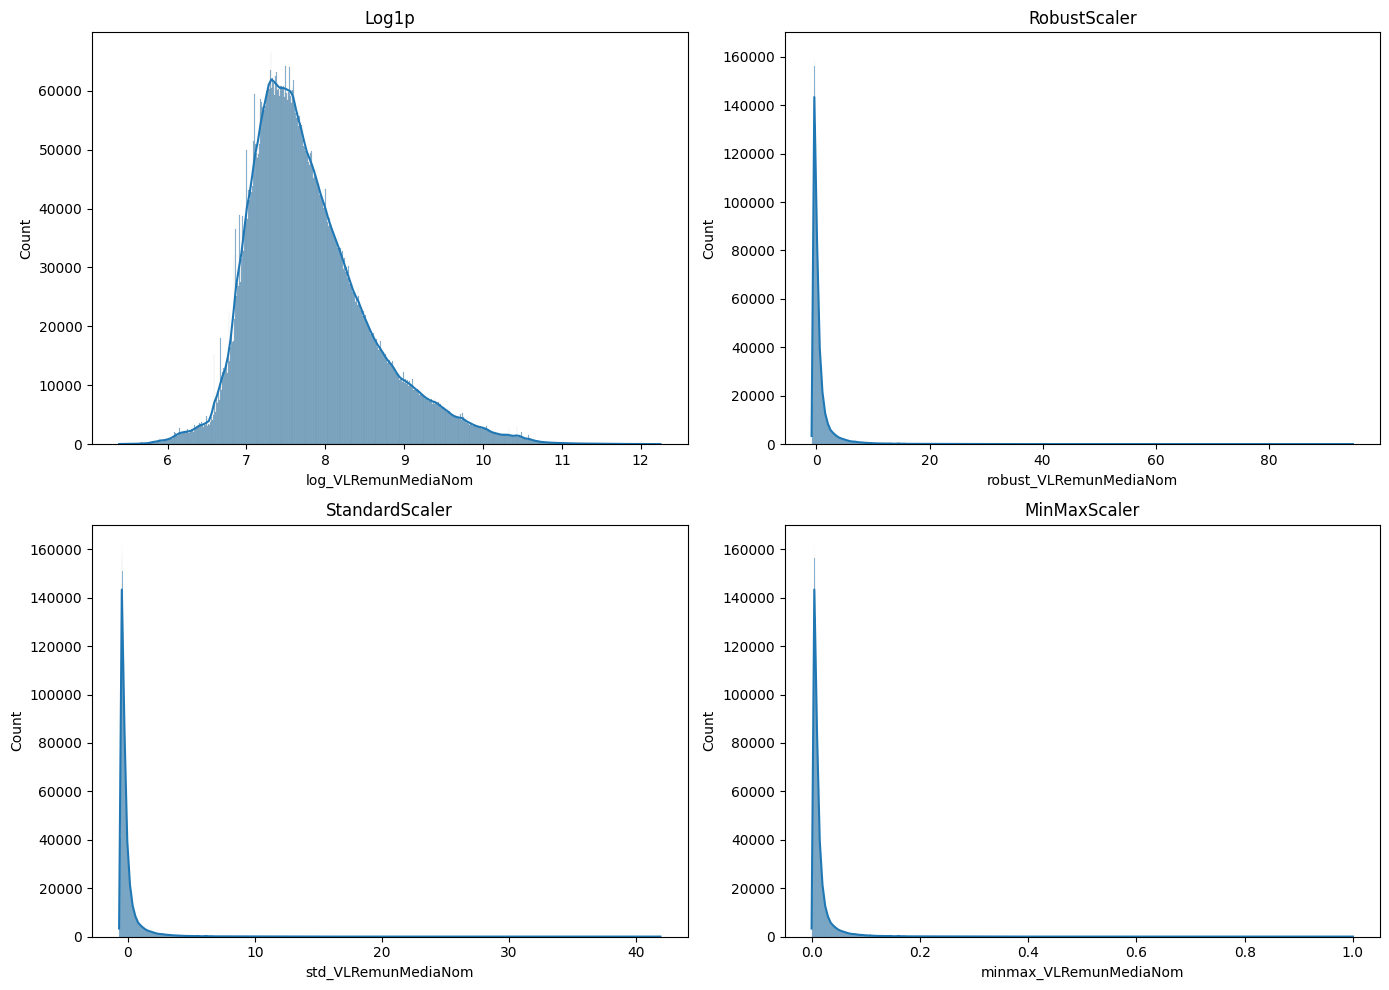

In [27]:


fig, axs = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(df_norm['log_VLRemunMediaNom'], ax=axs[0,0], kde=True).set(title='Log1p')
sns.histplot(df_norm['robust_VLRemunMediaNom'], ax=axs[0,1], kde=True).set(title='RobustScaler')
sns.histplot(df_norm['std_VLRemunMediaNom'], ax=axs[1,0], kde=True).set(title='StandardScaler')
sns.histplot(df_norm['minmax_VLRemunMediaNom'], ax=axs[1,1], kde=True).set(title='MinMaxScaler')
plt.tight_layout()
plt.show()


In [30]:


# Adiciona nova transformação com PowerTransformer (Yeo-Johnson)
scaler_yeoj = PowerTransformer(method='yeo-johnson')
df_norm['yeoj_VLRemunMediaNom'] = scaler_yeoj.fit_transform(df_norm[['VLRemunMediaNom']])

# Avaliação estatística: skew e kurtosis
print("📊 Skew e Curtose das transformações:")
for col in [
    'VLRemunMediaNom',
    'log_VLRemunMediaNom',
    'robust_VLRemunMediaNom',
    'std_VLRemunMediaNom',
    'minmax_VLRemunMediaNom',
    'yeoj_VLRemunMediaNom'
]:
    s = skew(df_norm[col])
    k = kurtosis(df_norm[col])
    print(f"{col:<30} | Skew: {s:>7.3f} | Kurtosis: {k:>7.3f}")


📊 Skew e Curtose das transformações:
VLRemunMediaNom                | Skew:   7.491 | Kurtosis: 116.078
log_VLRemunMediaNom            | Skew:   0.939 | Kurtosis:   1.182
robust_VLRemunMediaNom         | Skew:   7.491 | Kurtosis: 116.078
std_VLRemunMediaNom            | Skew:   7.491 | Kurtosis: 116.078
minmax_VLRemunMediaNom         | Skew:   7.491 | Kurtosis: 116.078
yeoj_VLRemunMediaNom           | Skew:   0.002 | Kurtosis:   0.231


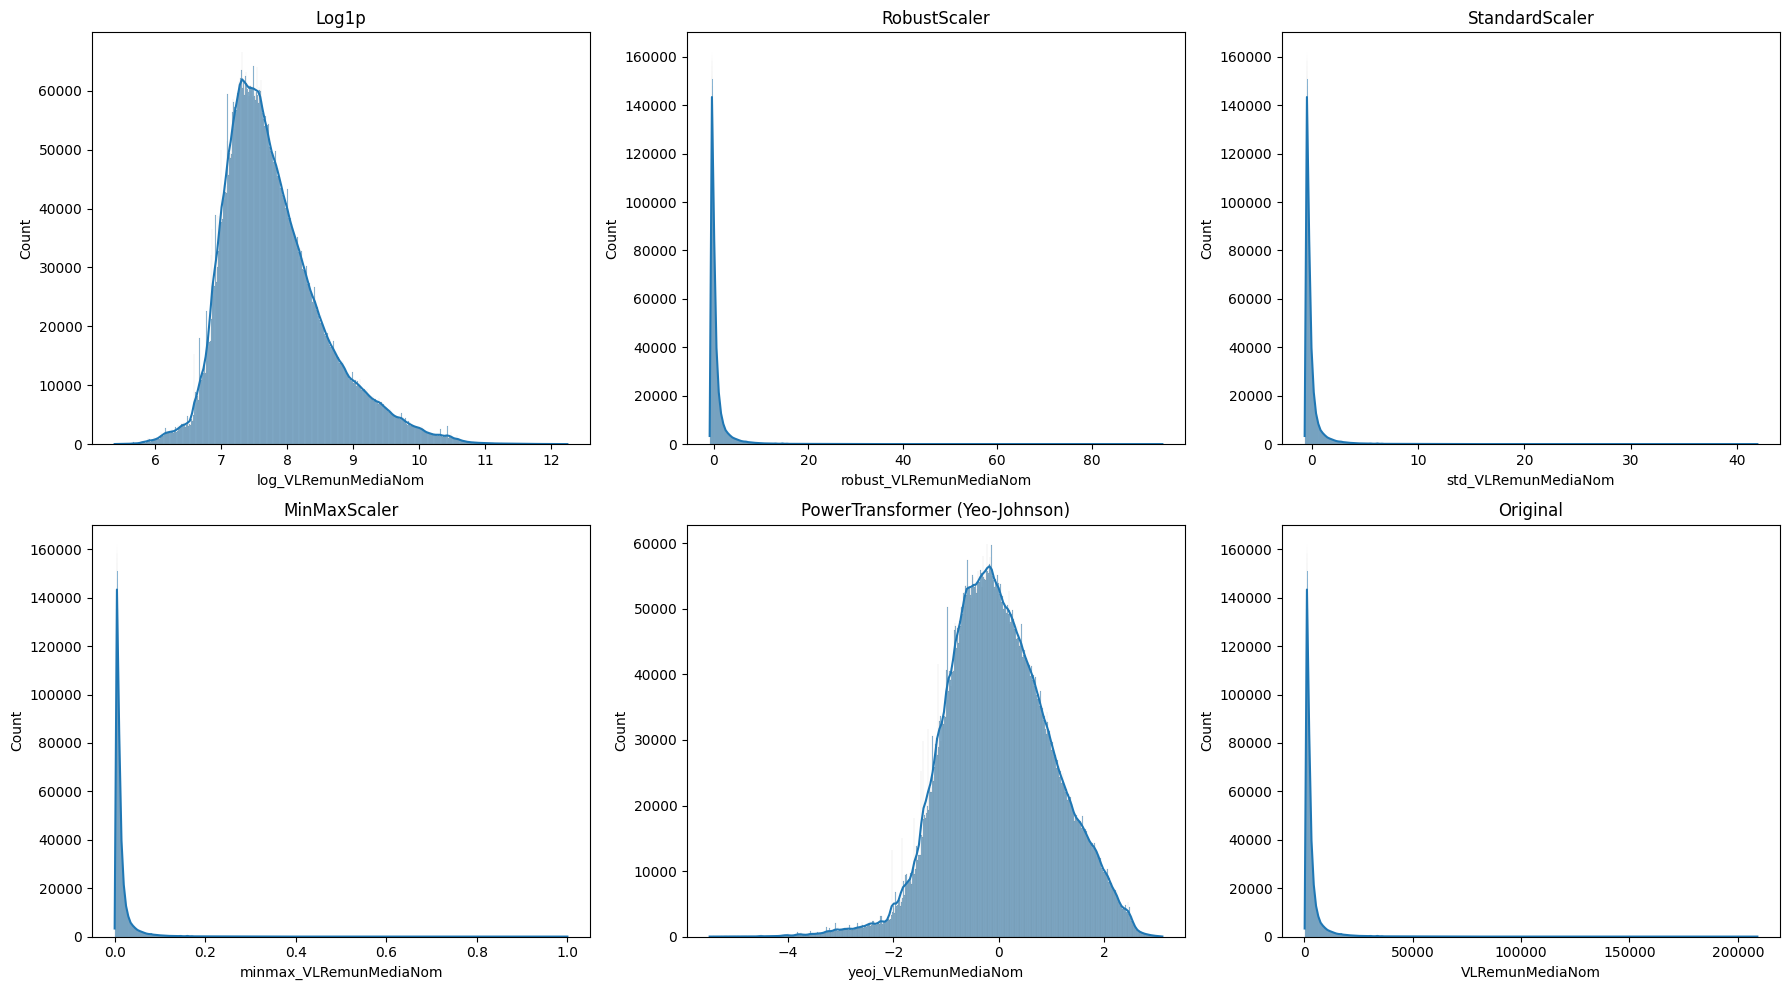

In [31]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

sns.histplot(df_norm['log_VLRemunMediaNom'], ax=axs[0,0], kde=True).set(title='Log1p')
sns.histplot(df_norm['robust_VLRemunMediaNom'], ax=axs[0,1], kde=True).set(title='RobustScaler')
sns.histplot(df_norm['std_VLRemunMediaNom'], ax=axs[0,2], kde=True).set(title='StandardScaler')

sns.histplot(df_norm['minmax_VLRemunMediaNom'], ax=axs[1,0], kde=True).set(title='MinMaxScaler')
sns.histplot(df_norm['yeoj_VLRemunMediaNom'], ax=axs[1,1], kde=True).set(title='PowerTransformer (Yeo-Johnson)')
sns.histplot(df_norm['VLRemunMediaNom'], ax=axs[1,2], kde=True).set(title='Original')

plt.tight_layout()
plt.show()


In [32]:
# Aplicar o filtro para TPVinculo
codigos_validos = [10, 15, 20, 25, 35, 40, 60, 65, 70, 75, 80]
df_filtrado = df[df['TPVinculo'].isin(codigos_validos)].copy()

# Criar nova coluna com a renda normalizada via transformação logarítmica (log1p)
df_filtrado['log_VLRemunMediaNom'] = np.log1p(df_filtrado['VLRemunMediaNom'])


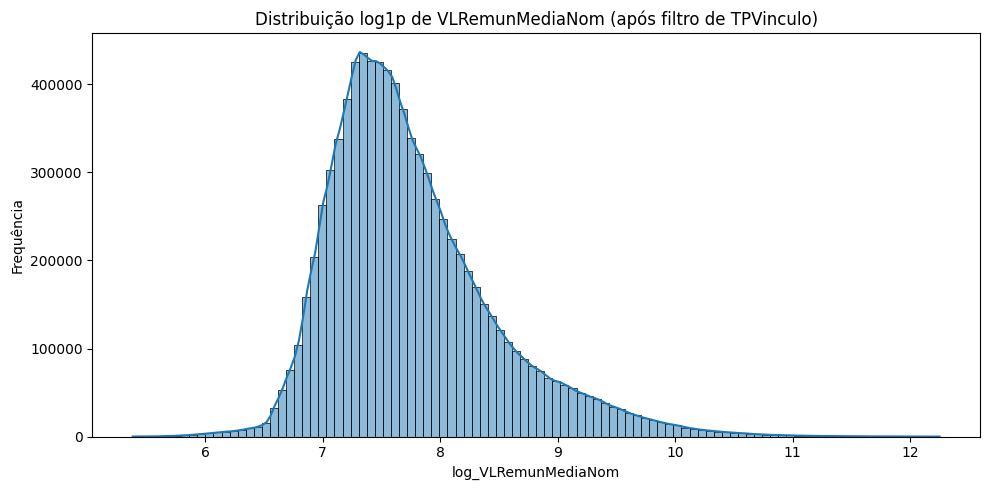

In [33]:

plt.figure(figsize=(10, 5))
sns.histplot(df_filtrado['log_VLRemunMediaNom'], bins=100, kde=True)
plt.title('Distribuição log1p de VLRemunMediaNom (após filtro de TPVinculo)')
plt.xlabel('log_VLRemunMediaNom')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()


In [34]:
df_filtrado.to_parquet("df_filtrado_log_VLRemunMediaNom.parquet", index=False)


In [35]:

# Reimportar o DataFrame a partir do arquivo Parquet
df_filtrado = pd.read_parquet("df_filtrado_log_VLRemunMediaNom.parquet")

# Verificar as primeiras linhas
df_filtrado.head()


,NRANO,CDMunicipio,TPVinculo,CDDesligamento,TPSalario,CDGrauEscolaridade,CDSexo,CDRacaCor,INPortadorDefic,CDTamanhoEstabelecimento,CDNaturezaJuridica,DTAdmissaoDeclarada,VLRemunMediaNom,VLRemunMediaSM,VLRemunDezembroNom,VLRemunDezembroSM,NRTempoEmprego,NRQtdHoraContr,VLSalarioContratual,NRCNPJCEI,NRCNPJRaiz,CDCBOOcupacao2002,CDCNAE20Classe,CDCNAE20Subclasse,NRIdade,INTrabParcial,Estoque_Total,Estoque_Fem,log_VLRemunMediaNom
0,2014,520650,35,0.0,1.0,7.0,1.0,99.0,0.0,7.0,1031.0,2011-02-01,1071.12,1.47,1053.94,1.45,47.9,40.0,545.00,02073211000180,02073211,992225,84116.0,8411600.0,48.0,0.0,242.0,169.0,6.977393
1,2014,351880,10,0.0,1.0,3.0,1.0,2.0,0.0,8.0,2062.0,2014-11-03,1378.55,1.89,1714.38,2.36,9.6,44.0,1050.06,89823918000225,89823918,783225,49302.0,4930202.0,34.0,0.0,340.0,48.0,7.229513
2,2014,354780,10,0.0,1.0,7.0,2.0,8.0,0.0,10.0,2062.0,2011-01-02,1760.84,2.42,1703.16,2.35,46.9,44.0,1145.59,64179724000127,64179724,517420,80111.0,8011101.0,25.0,0.0,4898.0,529.0,7.474114
3,2014,293330,10,0.0,5.0,5.0,2.0,8.0,0.0,9.0,2062.0,2014-01-10,757.39,1.04,752.48,1.03,2.9,44.0,3.31,01287588000845,01287588,764005,15319.0,1531901.0,20.0,0.0,773.0,592.0,6.631198
4,2014,130260,10,0.0,1.0,7.0,1.0,8.0,0.0,8.0,2062.0,NaT,749.30,1.03,747.00,1.03,22.3,44.0,747.00,08940297000187,08940297,412205,53202.0,5320201.0,27.0,0.0,345.0,252.0,6.620473


# Teste de hipóteses

In [36]:
# Total antes do filtro
total_antes = len(df_filtrado)

# Proporção de valores nulos no campo de carga horária
prop_nulos = df_filtrado['NRQtdHoraContr'].isna().mean()
print(f'Proporção de valores nulos em NRQtdHoraContr: {prop_nulos:.2%}')

# Remoção de nulos
df_horas = df_filtrado.dropna(subset=['NRQtdHoraContr', 'CDSexo'])

# Total após o filtro
total_depois = len(df_horas)

print(f'Total de registros antes do filtro: {total_antes:,}')
print(f'Total de registros após o filtro:  {total_depois:,}')
print(f'Total removido: {total_antes - total_depois:,}')


Proporção de valores nulos em NRQtdHoraContr: 0.00%
Total de registros antes do filtro: 8,705,138
Total de registros após o filtro:  8,705,138
Total removido: 0


In [37]:
df_horas['CDSexo'] = df_horas['CDSexo'].map({1: 'Masculino', 2: 'Feminino'})


In [38]:
df_horas.groupby('CDSexo')['NRQtdHoraContr'].describe()


,count,mean,std,min,25%,50%,75%,max
CDSexo,,,,,,,,
Feminino,3584086.0,40.034181,8.929743,0.0,36.0,44.0,44.0,99.0
Masculino,5121052.0,42.157315,8.298235,0.0,42.0,44.0,44.0,99.0


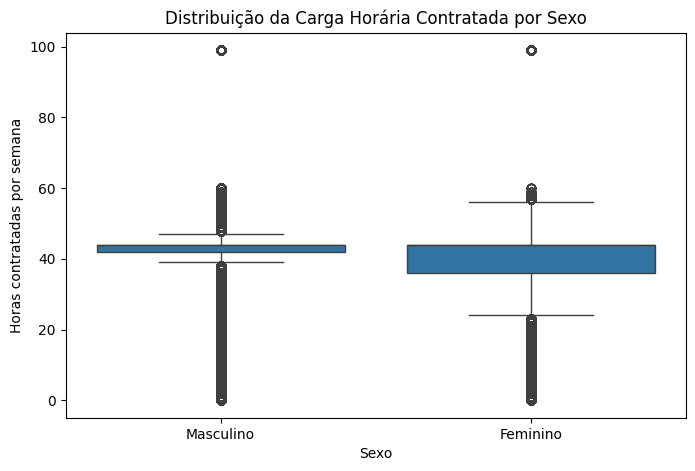

In [39]:

plt.figure(figsize=(8,5))
sns.boxplot(x='CDSexo', y='NRQtdHoraContr', data=df_horas)
plt.title("Distribuição da Carga Horária Contratada por Sexo")
plt.ylabel("Horas contratadas por semana")
plt.xlabel("Sexo")
plt.show()


In [42]:


# Separação por sexo
homens = df_horas[df_horas['CDSexo'] == 'Masculino']['NRQtdHoraContr']
mulheres = df_horas[df_horas['CDSexo'] == 'Feminino']['NRQtdHoraContr']

# Teste de diferença de médias
t_stat, p_valor = ttest_ind(homens, mulheres, equal_var=False)


print(f"Estatística t = {t_stat:.3f}")
print(f"p-valor = {p_valor:.4f}")


Estatística t = 355.364
p-valor = 0.0000


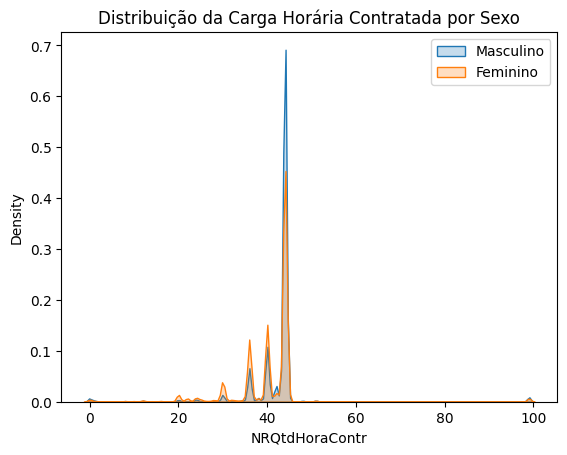

In [43]:
sns.kdeplot(data=homens, label="Masculino", fill=True)
sns.kdeplot(data=mulheres, label="Feminino", fill=True)
plt.title("Distribuição da Carga Horária Contratada por Sexo")
plt.xlabel("NRQtdHoraContr")
plt.legend()
plt.show()


In [44]:
# Após importar o parquet:
df_filtrado = pd.read_parquet("df_filtrado_log_VLRemunMediaNom.parquet")

# Garantir tipo string
df_filtrado['CDCBOOcupacao2002'] = df_filtrado['CDCBOOcupacao2002'].astype(str)

# Recriar a coluna com base no dicionário
ocupacoes_map = {
    '0': 'MEMBROS DAS FORÇAS ARMADAS, POLICIAIS E BOMBEIROS MILITARES',
    '1': 'MEMBROS SUPERIORES DO PODER PÚBLICO, DIRIGENTES, GERENTES',
    '2': 'PROFISSIONAIS DAS CIÊNCIAS E DAS ARTES',
    '3': 'TÉCNICOS DE NÍVEL MÉDIO',
    '4': 'TRABALHADORES DE SERVIÇOS ADMINISTRATIVOS',
    '5': 'TRABALHADORES DOS SERVIÇOS E VENDEDORES DO COMÉRCIO',
    '6': 'TRABALHADORES AGROPECUÁRIOS, FLORESTAIS E DA PESCA',
    '7': 'TRABALHADORES DA PRODUÇÃO INDUSTRIAL',
    '8': 'TRABALHADORES DA PRODUÇÃO INDUSTRIAL',
    '9': 'TRABALHADORES EM SERVIÇOS DE REPARAÇÃO E MANUTENÇÃO'
}

df_filtrado['GrupoOcupacao'] = df_filtrado['CDCBOOcupacao2002'].str[0].map(ocupacoes_map)


In [45]:
# Criação correta após garantir que df_filtrado tenha a coluna
df_horas_filtrado = df_filtrado[df_filtrado['CDSexo'].isin([1, 2])]


In [46]:
# Agrupar por grupo ocupacional e sexo
grupo_sexo_stats = (
    df_filtrado
    .dropna(subset=['NRQtdHoraContr', 'CDSexo', 'GrupoOcupacao'])
    .groupby(['GrupoOcupacao', 'CDSexo'])['NRQtdHoraContr']
    .agg(['count', 'mean', 'std'])
    .reset_index()
    .sort_values(['GrupoOcupacao', 'CDSexo'])
)

# Mostrar resultados
display(grupo_sexo_stats)


,GrupoOcupacao,CDSexo,count,mean,std
0,"MEMBROS DAS FORÇAS ARMADAS, POLICIAIS E BOMBEI...",1.0,4177,39.598276,3.077538
1,"MEMBROS DAS FORÇAS ARMADAS, POLICIAIS E BOMBEI...",2.0,1953,39.426523,4.697276
2,"MEMBROS SUPERIORES DO PODER PÚBLICO, DIRIGENTE...",1.0,227173,41.209862,12.541052
3,"MEMBROS SUPERIORES DO PODER PÚBLICO, DIRIGENTE...",2.0,171458,40.515170,11.054465
4,PROFISSIONAIS DAS CIÊNCIAS E DAS ARTES,1.0,418719,36.360091,13.994496
5,PROFISSIONAIS DAS CIÊNCIAS E DAS ARTES,2.0,548408,34.695265,12.427011
6,"TRABALHADORES AGROPECUÁRIOS, FLORESTAIS E DA P...",1.0,160560,43.584124,3.266576
7,"TRABALHADORES AGROPECUÁRIOS, FLORESTAIS E DA P...",2.0,19590,43.621899,3.982339
8,TRABALHADORES DA PRODUÇÃO INDUSTRIAL,1.0,1838857,43.373731,6.698915
9,TRABALHADORES DA PRODUÇÃO INDUSTRIAL,2.0,409315,44.118618,7.309120


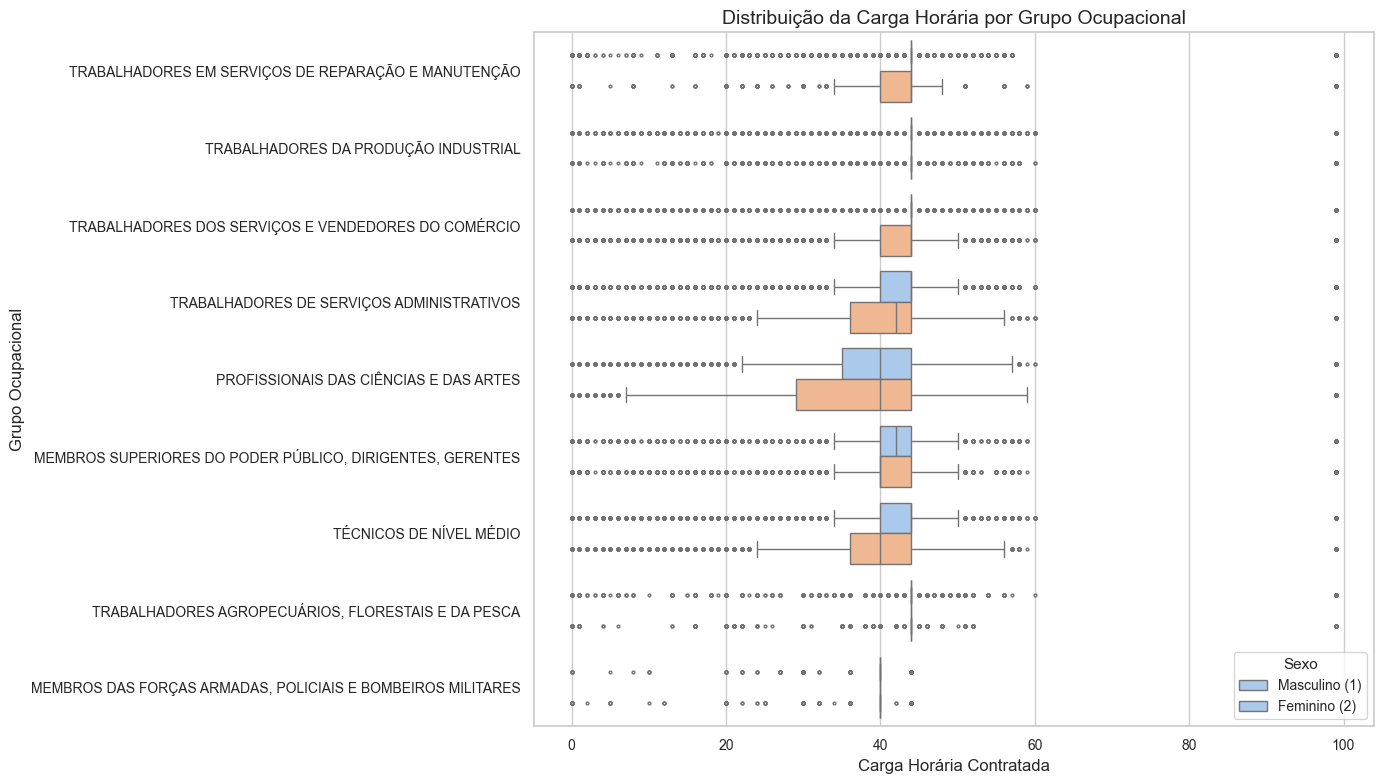

In [47]:

# Tema visual elegante
sns.set_theme(style="whitegrid")

# Número de grupos únicos
grupos = df_horas_filtrado['GrupoOcupacao'].dropna().unique()
num_grupos = len(grupos)

# Altura do gráfico ajustada automaticamente
altura = max(8, num_grupos * 0.7)  # aumento da altura

plt.figure(figsize=(14, altura))  # aumento da largura também
sns.boxplot(
    data=df_horas_filtrado,
    y='GrupoOcupacao',
    x='NRQtdHoraContr',
    hue='CDSexo',
    orient='h',
    palette='pastel',           # cores suaves e claras
    fliersize=2                 # reduz tamanho dos marcadores de outliers
)

plt.title('Distribuição da Carga Horária por Grupo Ocupacional', fontsize=14)
plt.xlabel('Carga Horária Contratada', fontsize=12)
plt.ylabel('Grupo Ocupacional', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Sexo', labels=['Masculino (1)', 'Feminino (2)'], fontsize=10, title_fontsize=11, loc='lower right')
plt.tight_layout()
plt.show()


In [48]:

# Reimporta o DataFrame
df_horas_filtrado = pd.read_parquet("df_filtrado_log_VLRemunMediaNom.parquet")

# Ordena os grupos pela mediana da carga horária
medianas = df_horas_filtrado.groupby("GrupoOcupacao")["NRQtdHoraContr"].median().sort_values()
ordem = medianas.index.tolist()

# Plot do boxplot aprimorado
plt.figure(figsize=(10, 8))  # aumenta altura
sns.set(style="whitegrid")   # estilo limpo

sns.boxplot(
    data=df_horas_filtrado,
    y="GrupoOcupacao",
    x="NRQtdHoraContr",
    hue="CDSexo",
    order=ordem,
    showfliers=False,        # não mostra outliers
    width=0.6                # largura das caixas
)

plt.title("Distribuição da Carga Horária por Grupo Ocupacional", fontsize=14)
plt.xlabel("Carga Horária Contratada")
plt.ylabel("Grupo Ocupacional")
plt.legend(title="Sexo", labels=["Masculino (1)", "Feminino (2)"], loc="lower right")
plt.tight_layout()
plt.show()


KeyError: 'GrupoOcupacao'

In [ ]:

# Lista para armazenar os resultados
resultados_teste_t = []

# Laço por cada grupo
for grupo in df_filtrado['GrupoOcupacao'].dropna().unique():
    sub = df_filtrado.query("GrupoOcupacao == @grupo and not NRQtdHoraContr.isna() and not CDSexo.isna()")

    fem = sub.loc[sub['CDSexo'] == 'Feminino', 'NRQtdHoraContr']
    masc = sub.loc[sub['CDSexo'] == 'Masculino', 'NRQtdHoraContr']
    
    # Teste t (sem assumir variâncias iguais)
    t_stat, p_val = ttest_ind(masc, fem, equal_var=False)
    
    resultados_teste_t.append({
        'GrupoOcupacao': grupo,
        'Media_Masc': masc.mean(),
        'Media_Fem': fem.mean(),
        'Dif_Medias': masc.mean() - fem.mean(),
        't_stat': t_stat,
        'p_valor': p_val,
        'N_Masc': len(masc),
        'N_Fem': len(fem)
    })

# DataFrame com resultados
import pandas as pd
df_teste_t = pd.DataFrame(resultados_teste_t).sort_values('GrupoOcupacao')

# Mostrar
display(df_teste_t)
